Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.SCD1CZ_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
Train batches: 602
Validation batches: 173
Test batches: 87
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
602/602 - 160s - 266ms/step - accuracy: 0.5028 - loss: 0.7040 - val_accuracy: 0.5215 - val_loss: 0.6881
Epoch 2/15
602/602 - 87s - 145ms/step - accuracy: 0.5089 - loss: 0.6962 - val_accuracy: 0.6262 - val_loss: 0.6873
Epoch 3/15
602/602 - 88s - 146ms/step - accuracy: 0.5144 - loss: 0.6939 - val_accuracy: 0.4999 - val_loss: 0.6890
Epoch 4/15
602/602 - 139s - 231ms/step - accuracy: 0.5197 - loss: 0.6931 - val_accuracy: 0.6046 - val_loss: 0.6777
Epoch 5/15
602/602 - 90s - 149ms/step - accuracy: 0.5203 - loss: 0.6920 - val_accuracy: 0.5357 - val_loss: 0.6764
Epoch 6/15
602/602 - 143s - 237ms/step - accuracy: 0.5294 - loss: 0.6905 - val_accuracy: 0.5816 - val_loss: 0.6683
Epoch 7/15
602/602 - 138s 

Epoch 1/30
602/602 - 6s - 10ms/step - accuracy: 0.5799 - loss: 0.6756 - val_accuracy: 0.6237 - val_loss: 0.6486
Epoch 2/30
602/602 - 2s - 3ms/step - accuracy: 0.5953 - loss: 0.6685 - val_accuracy: 0.6302 - val_loss: 0.6473
Epoch 3/30
602/602 - 2s - 3ms/step - accuracy: 0.5986 - loss: 0.6661 - val_accuracy: 0.6249 - val_loss: 0.6497
Epoch 4/30
602/602 - 2s - 3ms/step - accuracy: 0.5995 - loss: 0.6645 - val_accuracy: 0.6307 - val_loss: 0.6455
Epoch 5/30
602/602 - 2s - 3ms/step - accuracy: 0.6010 - loss: 0.6639 - val_accuracy: 0.6289 - val_loss: 0.6450
Epoch 6/30
602/602 - 2s - 3ms/step - accuracy: 0.6064 - loss: 0.6624 - val_accuracy: 0.6316 - val_loss: 0.6452
Epoch 7/30
602/602 - 2s - 3ms/step - accuracy: 0.6075 - loss: 0.6616 - val_accuracy: 0.6373 - val_loss: 0.6430
Epoch 8/30
602/602 - 2s - 4ms/step - accuracy: 0.6066 - loss: 0.6628 - val_accuracy: 0.6331 - val_loss: 0.6463
Epoch 9/30
602/602 - 2s - 3ms/step - accuracy: 0.6105 - loss: 0.6613 - val_accuracy: 0.6344 - val_loss: 0.6431


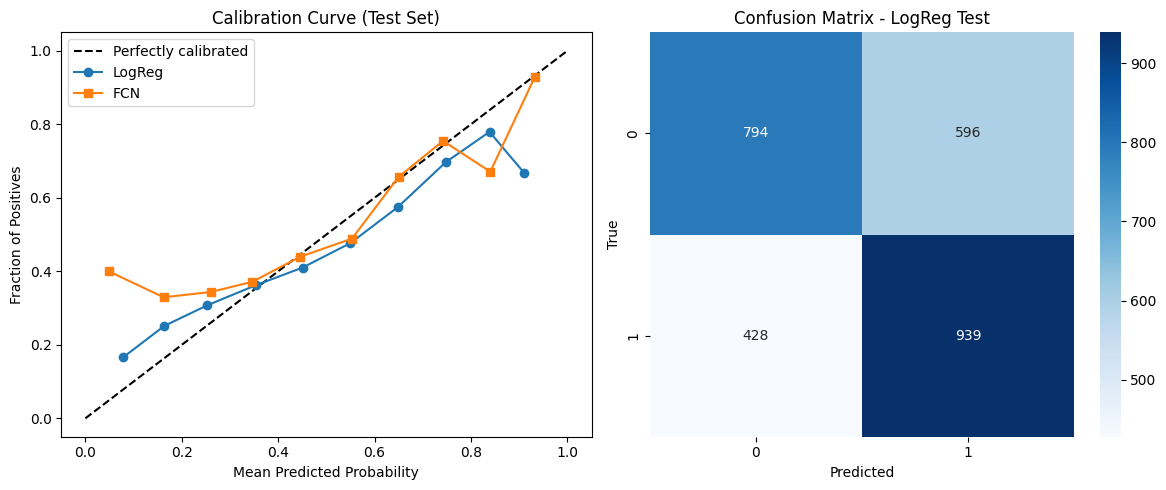

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

# --- Mixup Augmentation ---
def mixup_images(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    lam = tf.random.uniform([], 0, 1)
    lam = tf.maximum(lam, 1 - lam)
    indices = tf.random.shuffle(tf.range(batch_size))
    mixed_images = lam * images + (1 - lam) * tf.gather(images, indices)
    mixed_labels = lam * labels + (1 - lam) * tf.gather(labels, indices)
    return mixed_images, mixed_labels

def mixup_batch(images, labels, alpha=0.2):
    if len(labels.shape) == 1 or labels.shape[-1] != 2:
        labels = tf.one_hot(tf.cast(labels, tf.int32), 2)
    mixed_images, mixed_labels = mixup_images(images, labels, alpha)
    return mixed_images, mixed_labels

# --- Data Loading (shuffle before split for robust splits!) ---
def load_malaria_data():
    all_data, info = tfds.load('malaria', split='train', with_info=True, as_supervised=True)
    totalsamples = info.splits['train'].num_examples
    all_data = all_data.shuffle(buffer_size=totalsamples, seed=42)
    trainsize = int(0.7 * totalsamples)
    valsize = int(0.2 * totalsamples)
    testsize = totalsamples - trainsize - valsize
    train_data = all_data.take(trainsize)
    val_data = all_data.skip(trainsize).take(valsize)
    test_data = all_data.skip(trainsize + valsize).take(testsize)
    return train_data, val_data, test_data, totalsamples

def preprocess_and_onehot(image, label, target_size=224, num_classes=2):
    image = tf.image.resize(image, (target_size, target_size))
    image = image / 255.0
    label = tf.one_hot(label, num_classes)
    return image, label

trainds_raw, valds_raw, testds_raw, totalsamples = load_malaria_data()
batch_size = 32

# --- Map, batch, and augment sets ---
trainds = trainds_raw.map(lambda x, y: preprocess_and_onehot(x, y, 224, 2))
trainds = trainds.batch(batch_size, drop_remainder=True)
trainds = trainds.map(lambda x, y: mixup_batch(x, y, alpha=0.2)).prefetch(tf.data.AUTOTUNE)

valds = valds_raw.map(lambda x, y: preprocess_and_onehot(x, y, 224, 2)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
testds = testds_raw.map(lambda x, y: preprocess_and_onehot(x, y, 224, 2)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Diagnostic: print counts for sanity
print("Train batches:", sum(1 for _ in trainds))
print("Validation batches:", sum(1 for _ in valds))
print("Test batches:", sum(1 for _ in testds))

# --- Model Constructors ---
def create_efficientnetb3_extractor(input_shape=(224,224,3)):
    base = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base.layers[:-30]: layer.trainable = False
    for layer in base.layers[-30:]: layer.trainable = True
    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    return Model(inputs, x, name='EffnetB3Extractor')

def create_convnexttiny_extractor(input_shape=(224,224,3)):
    # If ConvNeXtTiny is unavailable, swap for MobileNetV2 or Xception
    base = tf.keras.applications.ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base.layers[:-30]: layer.trainable = False
    for layer in base.layers[-30:]: layer.trainable = True
    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.convnext.preprocess_input(inputs)
    x = base(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    return Model(inputs, x, name='ConvNeXtTinyExtractor')

effnet_extractor = create_efficientnetb3_extractor()
convnext_extractor = create_convnexttiny_extractor()
extractors = [effnet_extractor, convnext_extractor]

# --- Partial Fine-tuning with Mixup ---
def finetune_extractors_with_mixup(extractors, trainds, valds, epochs=15):
    for extractor in extractors:
        temp_input = layers.Input(shape=(224, 224, 3))
        features = extractor(temp_input)
        logits = layers.Dense(2, activation='softmax', name='temp_classification_head')(features)
        temp_model = Model(inputs=temp_input, outputs=logits)
        temp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss='categorical_crossentropy', metrics=['accuracy'])
        temp_model.fit(trainds, validation_data=valds, epochs=epochs, verbose=2)

finetune_extractors_with_mixup(extractors, trainds, valds, epochs=15)

# --- Robust Feature Extraction ---
def extract_features(model, dataset):
    features_list, labels_list = [], []
    for images, labels in dataset:
        # Handle empty batches or dataset
        if images.shape[0] == 0:
            continue
        features = model(images, training=False)
        features_list.append(features.numpy())
        labels_array = labels.numpy()
        if len(labels_array.shape) > 1 and labels_array.shape[1] == 2:
            labels_array = np.argmax(labels_array, axis=-1)
        labels_list.append(labels_array)
    if not features_list or not labels_list:
        print("Warning: No data in dataset for extraction!")
        return np.array([]), np.array([])
    return np.concatenate(features_list), np.concatenate(labels_list)

train_effnet, train_labels = extract_features(effnet_extractor, trainds)
val_effnet, val_labels = extract_features(effnet_extractor, valds)
test_effnet, test_labels = extract_features(effnet_extractor, testds)
train_convnext, _ = extract_features(convnext_extractor, trainds)
val_convnext, _ = extract_features(convnext_extractor, valds)
test_convnext, _ = extract_features(convnext_extractor, testds)

train_embeddings = np.concatenate([train_effnet, train_convnext], axis=1)
val_embeddings = np.concatenate([val_effnet, val_convnext], axis=1)
test_embeddings = np.concatenate([test_effnet, test_convnext], axis=1)

# --- Fusion Models ---
fusion_lr = LogisticRegression(max_iter=1000, random_state=42, verbose=0)
fusion_lr.fit(train_embeddings, train_labels)

fcn_model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(1024,)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])
fcn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
fcn_model.fit(train_embeddings, train_labels, validation_data=(val_embeddings, val_labels), epochs=30, batch_size=32, verbose=2)

# --- Evaluation ---
def evaluate_fusion(embeddings, labels, fusion_model, method_name):
    if isinstance(fusion_model, LogisticRegression):
        predictions = fusion_model.predict(embeddings)
        probabilities = fusion_model.predict_proba(embeddings)
    else:
        probabilities = fusion_model.predict(embeddings, verbose=0)
        predictions = np.argmax(probabilities, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    auc = roc_auc_score(labels, probabilities[:,1])
    fracpos, meanpred = calibration_curve(labels, probabilities[:,1], n_bins=10)
    cm = confusion_matrix(labels, predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "auc": auc,
        "calibration": (fracpos, meanpred),
        "confusion": cm,
        "predictions": predictions,
        "probs": probabilities
    }

test_metrics_lr = evaluate_fusion(test_embeddings, test_labels, fusion_lr, "Logistic Regression")
test_metrics_fcn = evaluate_fusion(test_embeddings, test_labels, fcn_model, "Small FCN")

print(f"Logistic Regression Test Set: Accuracy={test_metrics_lr['accuracy']:.4f}, F1-Score={test_metrics_lr['f1']:.4f}, ROC-AUC={test_metrics_lr['auc']:.4f}")
print(f"Small FCN Test Set: Accuracy={test_metrics_fcn['accuracy']:.4f}, F1-Score={test_metrics_fcn['f1']:.4f}, ROC-AUC={test_metrics_fcn['auc']:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.plot(test_metrics_lr['calibration'][1], test_metrics_lr['calibration'][0], 'o-', label='LogReg')
plt.plot(test_metrics_fcn['calibration'][1], test_metrics_fcn['calibration'][0], 's-', label='FCN')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Test Set)')
plt.legend()

plt.subplot(1,2,2)
sns.heatmap(test_metrics_lr['confusion'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LogReg Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()
